# Dataset

In [12]:
# Importing the relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import sounddevice as sd

# Checking TensorFlow and GPU availability
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available:  1


In [5]:
# Loading the speech_commands dataset

# Defining the path for the dataset
DATA_PATH = os.path.join("..", "data", "raw", "tensorflow_datasets")
os.makedirs(DATA_PATH, exist_ok=True)

try:
    builder = tfds.builder("speech_commands")
    builder.download_and_prepare(download_dir=DATA_PATH)
    ds_train_full, ds_info = tfds.load('speech_commands', split='train', with_info=True, shuffle_files=True, data_dir=DATA_PATH)
    ds_val_full = tfds.load('speech_commands', split='validation', shuffle_files=False, data_dir=DATA_PATH)
    ds_test_full = tfds.load('speech_commands', split='test', shuffle_files=False, data_dir=DATA_PATH)

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e # Stop execution if dataset loading fails

# Displaying the dataset information if successfully loaded
print("\nDataset Information (ds_info):")
print(ds_info)

Dl Completed...: 100%|██████████| 2/2 [00:00<00:00, 123.92 url/s]


Dataset speech_commands downloaded and prepared to /Users/anacleto/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


Dl Completed...: 100%|██████████| 2/2 [01:05<00:00, 32.75s/ url]
2025-05-30 16:09:41.702594: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-30 16:09:41.702788: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-30 16:09:41.703605: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-30 16:09:41.703856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-30 16:09:41.704023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dataset speech_commands downloaded and prepared to ../data/raw/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.

Dataset Information (ds_info):
tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "backgroun

In [ ]:
# Checking the features in the dataset
print("\nFeatures:")
print(ds_info.features)

# Label key for the dataset
label_key = 'label'

# Classes in the dataset
num_total_classes = ds_info.features[label_key].num_classes
print(f"\nTotal number of classes in the dataset: {num_total_classes}")

# String names of the classes
class_names_full = ds_info.features[label_key].names
print(f"\nFull list of class names:")
print(class_names_full)

# Number of examples in each split
print(f"\nNumber of examples in train split: {ds_info.splits['train'].num_examples}")
print(f"Number of examples in validation split: {ds_info.splits['validation'].num_examples}")
print(f"Number of examples in test split: {ds_info.splits['test'].num_examples}")

# Audio sample rate
SAMPLE_RATE = ds_info.features['audio'].sample_rate
print(f"\nSample rate: {SAMPLE_RATE} Hz")


Features:
FeaturesDict({
    'audio': Audio(shape=(None,), dtype=int16),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=12),
})

Total number of classes in the dataset: 12

Full list of class names (12):
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Number of examples in train split: 85511
Number of examples in validation split: 10102
Number of examples in test split: 4890

Sample rate: 16000 Hz



--- Single Example ---
Audio data shape: (16000,)
Audio data type: int16
Min audio value: -23075, Max audio value: 27155
Integer label: 5
String label: on


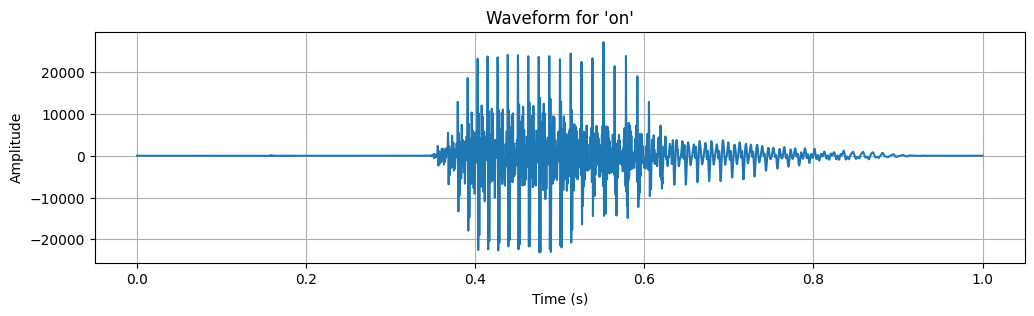

Playing audio for 'on'...
Playback finished.

MFCCs shape: (13, 32)


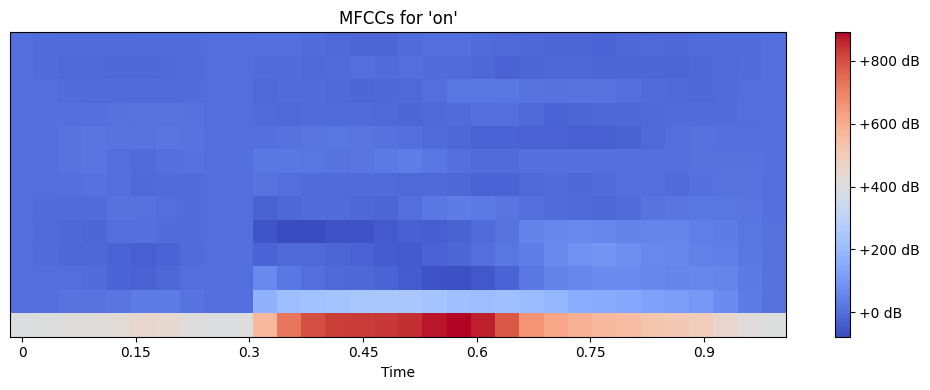

2025-05-30 18:53:32.310030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Checking one random example from the training dataset for visualization
for example in ds_train_full.take(1):
    audio_data = example['audio'].numpy()
    label_int = example[label_key].numpy()
    label_str = class_names_full[label_int]

    print(f"\n--- Single Example ---")
    print(f"Audio data shape: {audio_data.shape}") 
    print(f"Audio data type: {audio_data.dtype}")
    print(f"Min audio value: {np.min(audio_data)}, Max audio value: {np.max(audio_data)}")
    print(f"Integer label: {label_int}")
    print(f"String label: {label_str}")

    # Visualizing the waveform
    plt.figure(figsize=(12, 3))
    plt.plot(np.linspace(0, len(audio_data) / SAMPLE_RATE, num=len(audio_data)), audio_data)
    plt.title(f"Waveform for '{label_str}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Play the audio
    try:
        print(f"Playing audio for '{label_str}'...")
        sd.play(audio_data, SAMPLE_RATE)
        sd.wait()
        print("Playback finished.")
    except Exception as e:
        print(f"Could not play audio: {e}. Ensure sounddevice is installed and working.")

    # Extract and visualize MFCCs
    # MFCC parameters
    N_MFCC = 13  # Number of MFCCs to return
    N_FFT = 2048 # Length of the FFT window
    HOP_LENGTH = 512 # Number of samples between successive frames

    # Ensure audio_data is float for librosa
    mfccs = librosa.feature.mfcc(y=audio_data.astype(float),
                                 sr=SAMPLE_RATE,
                                 n_mfcc=N_MFCC,
                                 n_fft=N_FFT,
                                 hop_length=HOP_LENGTH)

    print(f"\nMFCCs shape: {mfccs.shape}") # (n_mfcc, n_frames)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB') # Colorbar shows decibels
    plt.title(f"MFCCs for '{label_str}'")
    plt.tight_layout()
    plt.show()